In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import folium 
from folium import plugins
from sklearn.metrics import r2_score


In [2]:
plt.rcParams['figure.figsize'] = 10,12

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('../../DataScraper/macedonia-data.csv')
df_italy = pd.read_csv('../../DataScraper/italy.csv')
df_spain = pd.read_csv('../../DataScraper/spain.csv')

In [5]:
df

,COUNTRY,COUNTRY_CODE,CONFIRMED,DEATHS,RECOVERED,ACTIVE,DATE
0,"Macedonia, Republic of",MK,0,0,0,0,2020-01-22
1,"Macedonia, Republic of",MK,0,0,0,0,2020-01-23
2,"Macedonia, Republic of",MK,0,0,0,0,2020-01-24
3,"Macedonia, Republic of",MK,0,0,0,0,2020-01-25
4,"Macedonia, Republic of",MK,0,0,0,0,2020-01-26
...,...,...,...,...,...,...,...
226,"Macedonia, Republic of",MK,14871,609,12054,2208,2020-09-04
227,"Macedonia, Republic of",MK,14998,614,12149,2235,2020-09-05
228,"Macedonia, Republic of",MK,15090,617,12235,2238,2020-09-06
229,"Macedonia, Republic of",MK,15127,623,12486,2018,2020-09-07


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231 entries, 0 to 230
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   COUNTRY       231 non-null    object
 1   COUNTRY_CODE  231 non-null    object
 2   CONFIRMED     231 non-null    int64 
 3   DEATHS        231 non-null    int64 
 4   RECOVERED     231 non-null    int64 
 5   ACTIVE        231 non-null    int64 
 6   DATE          231 non-null    object
dtypes: int64(4), object(3)
memory usage: 12.8+ KB


In [7]:
df['DAILY NEW CASES'] = df['CONFIRMED'] - df['CONFIRMED'].shift(1)
df['DAILY NEW DEATHS'] = df['DEATHS'] - df['DEATHS'].shift(1)
df['DAILY CURED'] = df['RECOVERED'] - df['RECOVERED'].shift(1)

In [8]:
df

,COUNTRY,COUNTRY_CODE,CONFIRMED,DEATHS,RECOVERED,ACTIVE,DATE,DAILY NEW CASES,DAILY NEW DEATHS,DAILY CURED
0,"Macedonia, Republic of",MK,0,0,0,0,2020-01-22,NaN,NaN,NaN
1,"Macedonia, Republic of",MK,0,0,0,0,2020-01-23,0.0,0.0,0.0
2,"Macedonia, Republic of",MK,0,0,0,0,2020-01-24,0.0,0.0,0.0
3,"Macedonia, Republic of",MK,0,0,0,0,2020-01-25,0.0,0.0,0.0
4,"Macedonia, Republic of",MK,0,0,0,0,2020-01-26,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
226,"Macedonia, Republic of",MK,14871,609,12054,2208,2020-09-04,109.0,3.0,89.0
227,"Macedonia, Republic of",MK,14998,614,12149,2235,2020-09-05,127.0,5.0,95.0
228,"Macedonia, Republic of",MK,15090,617,12235,2238,2020-09-06,92.0,3.0,86.0
229,"Macedonia, Republic of",MK,15127,623,12486,2018,2020-09-07,37.0,6.0,251.0


In [9]:
df['DAILY NEW CASES'] = df['DAILY NEW CASES'].fillna(0)
df['DAILY NEW DEATHS'] = df['DAILY NEW DEATHS'].fillna(0)
df['DAILY CURED'] = df['DAILY CURED'].fillna(0)
df

,COUNTRY,COUNTRY_CODE,CONFIRMED,DEATHS,RECOVERED,ACTIVE,DATE,DAILY NEW CASES,DAILY NEW DEATHS,DAILY CURED
0,"Macedonia, Republic of",MK,0,0,0,0,2020-01-22,0.0,0.0,0.0
1,"Macedonia, Republic of",MK,0,0,0,0,2020-01-23,0.0,0.0,0.0
2,"Macedonia, Republic of",MK,0,0,0,0,2020-01-24,0.0,0.0,0.0
3,"Macedonia, Republic of",MK,0,0,0,0,2020-01-25,0.0,0.0,0.0
4,"Macedonia, Republic of",MK,0,0,0,0,2020-01-26,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
226,"Macedonia, Republic of",MK,14871,609,12054,2208,2020-09-04,109.0,3.0,89.0
227,"Macedonia, Republic of",MK,14998,614,12149,2235,2020-09-05,127.0,5.0,95.0
228,"Macedonia, Republic of",MK,15090,617,12235,2238,2020-09-06,92.0,3.0,86.0
229,"Macedonia, Republic of",MK,15127,623,12486,2018,2020-09-07,37.0,6.0,251.0


In [10]:
df['DATE'] = pd.to_datetime(df['DATE'])
total_per_month_df = df.groupby(df['DATE'].dt.strftime('%B'))['DAILY NEW CASES'].sum().sort_values(ascending=False).to_frame()


In [11]:
total_per_month_df.style.background_gradient(cmap='Reds')

,DAILY NEW CASES
DATE,
July,4420.000000
June,4108.000000
August,3587.000000
April,1136.000000
September,885.000000
May,761.000000
March,328.000000
February,1.000000
January,0.000000


In [12]:
total_per_month_df = df.groupby(df['DATE'].rename("MONTH").dt.strftime('%B')).agg(
TOTAL_CASES = pd.NamedAgg(column='DAILY NEW CASES', aggfunc=sum),
TOTAL_DEATHS = pd.NamedAgg(column='DAILY NEW DEATHS', aggfunc=sum),
TOTAL_CURED = pd.NamedAgg(column='DAILY CURED', aggfunc=sum),
)

In [13]:
total_per_month_df

,TOTAL_CASES,TOTAL_DEATHS,TOTAL_CURED
MONTH,,,
April,1136.0,68.0,726.0
August,3587.0,117.0,4603.0
February,1.0,0.0,0.0
January,0.0,0.0,0.0
July,4420.0,184.0,4079.0
June,4108.0,169.0,923.0
March,328.0,9.0,12.0
May,761.0,56.0,814.0
September,885.0,28.0,1543.0


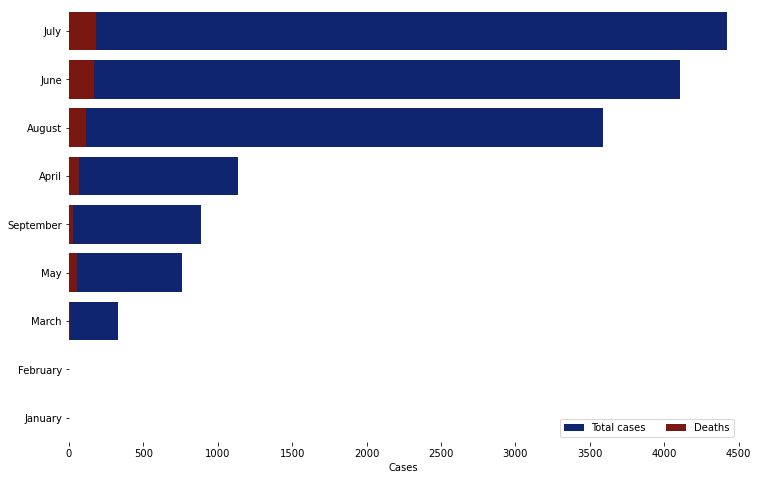

In [14]:
f, ax = plt.subplots(figsize = (12,8))
data = total_per_month_df.copy()
data['MONTH'] = data.index
data.sort_values('TOTAL_CASES', ascending =  False, inplace = True)
sns.set_color_codes("dark")
sns.barplot(x = "TOTAL_CASES", y = "MONTH", data = data, label = "Total cases", color = "b")
sns.set_color_codes("dark")
sns.barplot(x = "TOTAL_DEATHS", y = "MONTH", data = data, label = "Deaths", color = "r")

ax.legend(ncol = 2, loc = "lower right", frameon = True)
ax.set(xlim = (0, 4500), ylabel = "", xlabel="Cases")
sns.despine(left = True, bottom = True)


In [15]:
import plotly
plotly.io.renderers.default = 'browser'

In [16]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['DATE'], y=df['DAILY NEW CASES'], mode='lines+markers', name='Total Cases'))
fig.update_layout(title_text='Coronavirus cases in North Macedonia', plot_bgcolor='rgb(230,230,230)')
fig.show()

In [17]:
import plotly.express as px
fig = px.bar(df, x="DATE", y= "DAILY NEW CASES", barmode='group', height = 400)
fig.update_layout(title_text='Coronavirus cases in North Macedonia', plot_bgcolor='rgb(230,230,230)')
fig.show()

In [18]:
df_italy['DATE'] = pd.to_datetime(df_italy['DATE'])
df_spain['DATE'] = pd.to_datetime(df_spain['DATE'])

In [19]:
df_italy['DAILY NEW CASES'] = df_italy['CONFIRMED'] - df_italy['CONFIRMED'].shift(1)
df_italy['DAILY NEW DEATHS'] = df_italy['DEATHS'] - df_italy['DEATHS'].shift(1)
df_italy['DAILY CURED'] = df_italy['RECOVERED'] - df_italy['RECOVERED'].shift(1)

In [20]:
df_italy['DAILY NEW CASES'] = df_italy['DAILY NEW CASES'].fillna(0)
df_italy['DAILY NEW DEATHS'] = df_italy['DAILY NEW DEATHS'].fillna(0)
df_italy['DAILY CURED'] = df_italy['DAILY CURED'].fillna(0)
df_italy

,COUNTRY,COUNTRY_CODE,CONFIRMED,DEATHS,RECOVERED,ACTIVE,DATE,DAILY NEW CASES,DAILY NEW DEATHS,DAILY CURED
0,Italy,IT,0,0,0,0,2020-01-22,0.0,0.0,0.0
1,Italy,IT,0,0,0,0,2020-01-23,0.0,0.0,0.0
2,Italy,IT,0,0,0,0,2020-01-24,0.0,0.0,0.0
3,Italy,IT,0,0,0,0,2020-01-25,0.0,0.0,0.0
4,Italy,IT,0,0,0,0,2020-01-26,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
226,Italy,IT,274644,35518,209027,30099,2020-09-04,1732.0,11.0,537.0
227,Italy,IT,276338,35534,209610,31194,2020-09-05,1694.0,16.0,583.0
228,Italy,IT,277634,35541,210015,32078,2020-09-06,1296.0,7.0,405.0
229,Italy,IT,278784,35553,210238,32993,2020-09-07,1150.0,12.0,223.0


In [21]:
df_spain['DAILY NEW CASES'] = df_spain['CONFIRMED'] - df_spain['CONFIRMED'].shift(1)
df_spain['DAILY NEW DEATHS'] = df_spain['DEATHS'] - df_spain['DEATHS'].shift(1)
df_spain['DAILY CURED'] = df_spain['RECOVERED'] - df_spain['RECOVERED'].shift(1)

In [22]:
df_spain['DAILY NEW CASES'] = df_spain['DAILY NEW CASES'].fillna(0)
df_spain['DAILY NEW DEATHS'] = df_spain['DAILY NEW DEATHS'].fillna(0)
df_spain['DAILY CURED'] = df_spain['DAILY CURED'].fillna(0)
df_spain
mean = df_spain["DAILY NEW CASES"].mean()
df_spain[df_spain['DAILY NEW CASES'] < 0] = mean
df_spain
       

,COUNTRY,COUNTRY_CODE,CONFIRMED,DEATHS,RECOVERED,ACTIVE,DATE,DAILY NEW CASES,DAILY NEW DEATHS,DAILY CURED
0,Spain,ES,0.0,0.0,0.0,0.0,2020-01-22 00:00:00,0.0,0.0,0.0
1,Spain,ES,0.0,0.0,0.0,0.0,2020-01-23 00:00:00,0.0,0.0,0.0
2,Spain,ES,0.0,0.0,0.0,0.0,2020-01-24 00:00:00,0.0,0.0,0.0
3,Spain,ES,0.0,0.0,0.0,0.0,2020-01-25 00:00:00,0.0,0.0,0.0
4,Spain,ES,0.0,0.0,0.0,0.0,2020-01-26 00:00:00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
226,Spain,ES,498989.0,29418.0,150376.0,319195.0,2020-09-04 00:00:00,10476.0,184.0,0.0
227,Spain,ES,498989.0,29418.0,150376.0,319195.0,2020-09-05 00:00:00,0.0,0.0,0.0
228,Spain,ES,498989.0,29418.0,150376.0,319195.0,2020-09-06 00:00:00,0.0,0.0,0.0
229,Spain,ES,525549.0,29516.0,150376.0,345657.0,2020-09-07 00:00:00,26560.0,98.0,0.0


In [23]:
from plotly.subplots import make_subplots

fig = make_subplots(
rows = 2, cols =2,
specs= [[{},{}],
        [{"colspan": 2}, None]],
subplot_titles=("North Macedonia", "Italy", "Spain"))

fig.add_trace(go.Bar(x=df['DATE'], \
                     y = df['DAILY NEW CASES'], \
                     marker = dict(color = df['DAILY NEW CASES'], \
                                   coloraxis="coloraxis")), row=1 , col=1)

fig.add_trace(go.Bar(x=df_italy['DATE'], \
                     y = df_italy['DAILY NEW CASES'], \
                     marker = dict(color = df_italy['DAILY NEW CASES'], \
                                   coloraxis="coloraxis")), row=1 , col=2)

fig.add_trace(go.Bar(x=df_spain['DATE'], \
                     y = df_spain['DAILY NEW CASES'], \
                     marker = dict(color = df_spain['DAILY NEW CASES'], \
                                   coloraxis="coloraxis")), row=2, col=1)

fig.update_layout(coloraxis=dict(colorscale = 'Bluered_r'), showlegend = False)

fig.update_layout(plot_bgcolor='rgb(230,230,230)')

fig.show()

In [24]:
from fbprophet.diagnostics import cross_validation
from fbprophet import Prophet

In [25]:
data = pd.read_csv('./covid19-data.csv')

In [26]:
data.head()

,Date,Country/Region,Province/State,Lat,Long,Confirmed,Recovered,Deaths
0,2020-01-22,Afghanistan,NaN,33.93911,67.709953,0,0.0,0
1,2020-01-23,Afghanistan,NaN,33.93911,67.709953,0,0.0,0
2,2020-01-24,Afghanistan,NaN,33.93911,67.709953,0,0.0,0
3,2020-01-25,Afghanistan,NaN,33.93911,67.709953,0,0.0,0
4,2020-01-26,Afghanistan,NaN,33.93911,67.709953,0,0.0,0


In [27]:
data.corr()

,Lat,Long,Confirmed,Recovered,Deaths
Lat,1.000000,-0.119971,0.017133,-0.002509,0.053193
Long,-0.119971,1.000000,-0.075300,-0.064406,-0.109815
Confirmed,0.017133,-0.075300,1.000000,0.910567,0.910559
Recovered,-0.002509,-0.064406,0.910567,1.000000,0.772743
Deaths,0.053193,-0.109815,0.910559,0.772743,1.000000


In [28]:
data['Date'] = pd.to_datetime(data['Date'], infer_datetime_format=True)
data['CurrentCase'] = data['Confirmed'] - data['Recovered'] - data['Deaths']

In [29]:
date_df = data.groupby('Date')[['Confirmed' ,'Recovered', 'Deaths', 'CurrentCase']].sum()

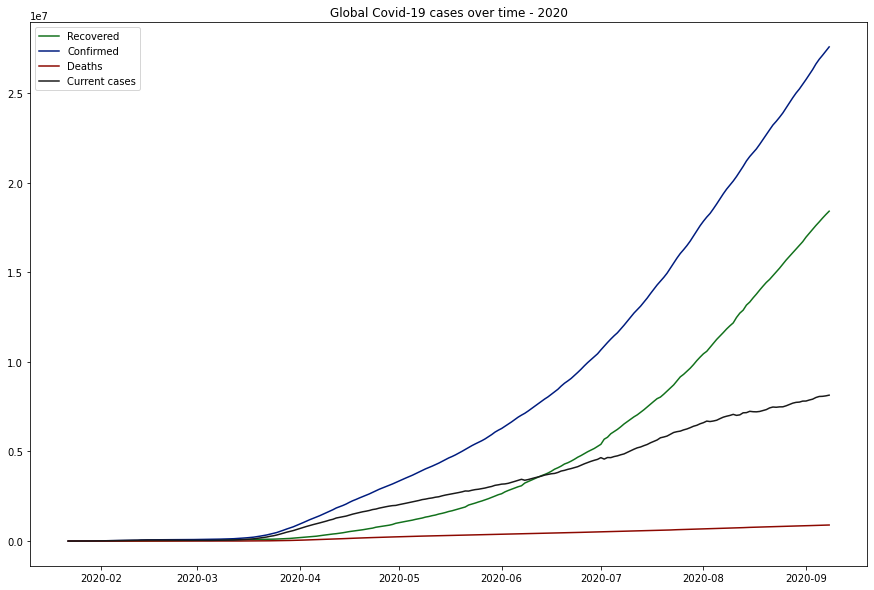

In [30]:
plt.figure(figsize=(15,10))
plt.plot(date_df["Recovered"],color='g',label='Recovered')
plt.plot(date_df["Confirmed"],color='b', label='Confirmed')
plt.plot(date_df["Deaths"],color='r',label='Deaths')
plt.plot(date_df['CurrentCase'],color='k', label='Current cases')
plt.title('Global Covid-19 cases over time - 2020')
plt.legend();

In [31]:
from fbprophet import Prophet
model = Prophet()
model.add_seasonality(name='Monthly', period=30.42, fourier_order=5)

In [32]:
global_cases = date_df.reset_index()
confirmed_df = global_cases[['Date', 'Confirmed']]
recovered_df = global_cases[['Date', 'Recovered']]
deaths_df = global_cases[['Date', 'Deaths']]
current_df = global_cases[['Date', 'CurrentCase']]

In [33]:
def rename_func(dataframe):
    cols = dataframe.columns
    dataframe = dataframe.rename(columns= {cols[0]: 'ds', cols[1]:'y'})
    return dataframe

In [34]:
confirmed_df = rename_func(confirmed_df)
recovered_df = rename_func(recovered_df)
deaths_df = rename_func(deaths_df)
current_df = rename_func(current_df)

In [35]:
def train_test_split(dataframe, ratio):
    divisor = round((ratio/100)*dataframe.shape[0])
    train = dataframe.iloc[:divisor]
    test = dataframe.iloc[divisor:]
    return train, test, divisor

In [36]:
def check_metrics(test, predictions):
    R2_score = r2_score(test['y'],predictions['yhat'].iloc[divisor:])
    print(f"R-square Score: {R2_score}")

In [37]:
# World
data_world = rename_func(confirmed_df)
m = Prophet()
m.add_seasonality(name='Monthly', period=30.42, fourier_order=5)
daily_new_train, daily_new_test, divisor = train_test_split(data_world, 80)
daily_new_train.shape , daily_new_test.shape
m.fit(daily_new_train)
future_dates_world = m.make_future_dataframe(periods=46)
predictions_world = m.predict(future_dates_world)
predictions_world.tail()


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Monthly,Monthly_lower,Monthly_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
226,2020-09-04,2.363390e+07,2.262877e+07,2.461065e+07,2.267535e+07,2.467262e+07,-51273.583928,-51273.583928,-51273.583928,-36122.579392,-36122.579392,-36122.579392,15151.004535,15151.004535,15151.004535,0.0,0.0,0.0,2.359778e+07
227,2020-09-05,2.383088e+07,2.280990e+07,2.483503e+07,2.283404e+07,2.491396e+07,-51400.829703,-51400.829703,-51400.829703,-46232.870851,-46232.870851,-46232.870851,5167.958852,5167.958852,5167.958852,0.0,0.0,0.0,2.378464e+07
228,2020-09-06,2.402785e+07,2.295724e+07,2.510765e+07,2.298428e+07,2.514171e+07,-50275.349970,-50275.349970,-50275.349970,-50795.509870,-50795.509870,-50795.509870,-520.159900,-520.159900,-520.159900,0.0,0.0,0.0,2.397705e+07
229,2020-09-07,2.422482e+07,2.307706e+07,2.532853e+07,2.314134e+07,2.538132e+07,-44589.364011,-44589.364011,-44589.364011,-54696.606833,-54696.606833,-54696.606833,-10107.242822,-10107.242822,-10107.242822,0.0,0.0,0.0,2.417013e+07
230,2020-09-08,2.442180e+07,2.325962e+07,2.556495e+07,2.329632e+07,2.562308e+07,-34239.177193,-34239.177193,-34239.177193,-43335.389858,-43335.389858,-43335.389858,-9096.212665,-9096.212665,-9096.212665,0.0,0.0,0.0,2.437846e+07


In [38]:
daily_new_train.head()

,ds,y
0,2020-01-22,555
1,2020-01-23,654
2,2020-01-24,941
3,2020-01-25,1434
4,2020-01-26,2118


In [39]:
predictions_world.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Monthly,Monthly_lower,Monthly_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-22,-9188.353310,-21800.534510,132773.193808,-9188.353310,-9188.353310,72523.462379,72523.462379,72523.462379,67844.789780,67844.789780,67844.789780,-4678.672598,-4678.672598,-4678.672598,0.0,0.0,0.0,58656.436471
1,2020-01-23,-3855.659987,-26553.225210,137151.108074,-3855.659987,-3855.659987,54889.442514,54889.442514,54889.442514,58972.767112,58972.767112,58972.767112,4083.324598,4083.324598,4083.324598,0.0,0.0,0.0,55117.107126
2,2020-01-24,1477.033336,-31729.869800,125717.489989,1477.033336,1477.033336,28295.790669,28295.790669,28295.790669,43446.795204,43446.795204,43446.795204,15151.004535,15151.004535,15151.004535,0.0,0.0,0.0,44923.828540
3,2020-01-25,6809.726659,-64197.974614,89854.129922,6809.726659,6809.726659,-487.646597,-487.646597,-487.646597,4680.312255,4680.312255,4680.312255,5167.958852,5167.958852,5167.958852,0.0,0.0,0.0,11490.038915
4,2020-01-26,12142.419982,-100452.754343,65534.905776,12142.419982,12142.419982,-23362.652231,-23362.652231,-23362.652231,-23882.812131,-23882.812131,-23882.812131,-520.159900,-520.159900,-520.159900,0.0,0.0,0.0,-11740.392148


R-square Score: 0.6640408348646573


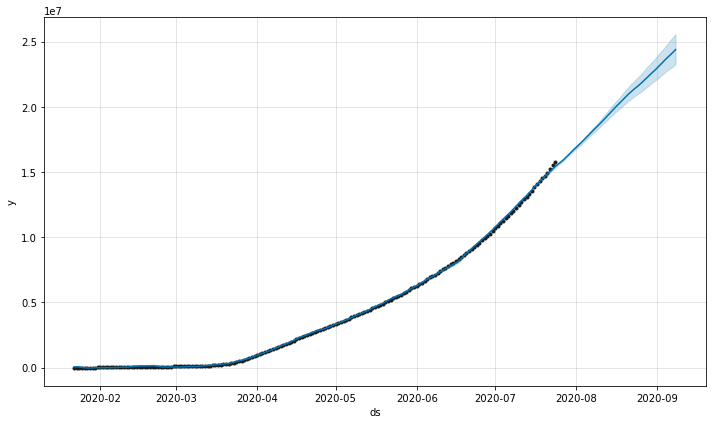

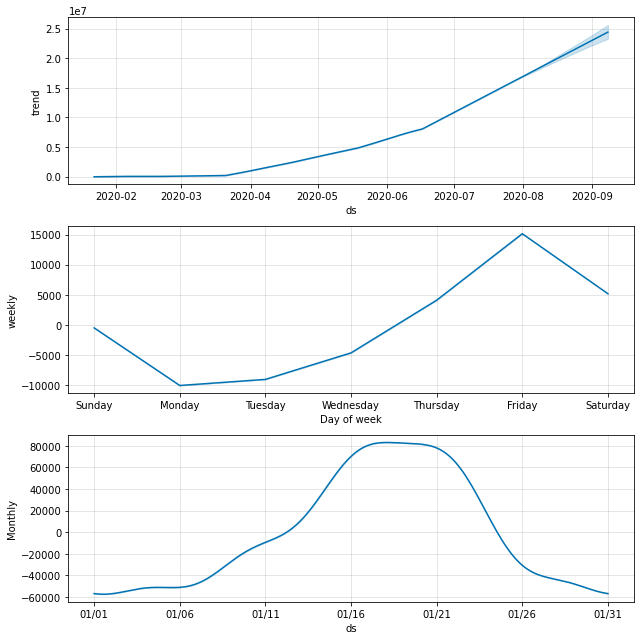

In [40]:
m.plot(predictions_world);
m.plot_components(predictions_world);
check_metrics(daily_new_test, predictions_world)

In [41]:
# Macedonia
data_macedonia = df[['DATE','DAILY NEW CASES']]
data_macedonia.columns = ['ds','y']
m = Prophet()
m.add_seasonality(name='Monthly', period=30.42, fourier_order=5)
daily_new_train, daily_new_test, divisor = train_test_split(data_macedonia, 90)
daily_new_train.shape , daily_new_test.shape
m.fit(daily_new_train)
future_dates_mk = m.make_future_dataframe(periods=23)
predictions_mk = m.predict(future_dates_mk)
predictions_mk.tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Monthly,Monthly_lower,Monthly_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
226,2020-09-04,180.158667,139.361528,228.110911,179.747893,180.588593,-4.035259,-4.035259,-4.035259,5.260637,5.260637,5.260637,9.295896,9.295896,9.295896,0.0,0.0,0.0,185.419304
227,2020-09-05,181.200412,147.519346,233.144997,180.758053,181.655241,-4.717951,-4.717951,-4.717951,6.643217,6.643217,6.643217,11.361168,11.361168,11.361168,0.0,0.0,0.0,187.843628
228,2020-09-06,182.242156,133.793110,217.278211,181.764798,182.739629,-3.360810,-3.360810,-3.360810,-6.638901,-6.638901,-6.638901,-3.278092,-3.278092,-3.278092,0.0,0.0,0.0,175.603255
229,2020-09-07,183.283901,127.995255,206.201289,182.774644,183.815189,0.003813,0.003813,0.003813,-16.143352,-16.143352,-16.143352,-16.147166,-16.147166,-16.147166,0.0,0.0,0.0,167.140548
230,2020-09-08,184.325645,136.715776,217.262410,183.777416,184.901769,4.295698,4.295698,4.295698,-4.980463,-4.980463,-4.980463,-9.276161,-9.276161,-9.276161,0.0,0.0,0.0,179.345182


R-square Score: -2.6178324083861915


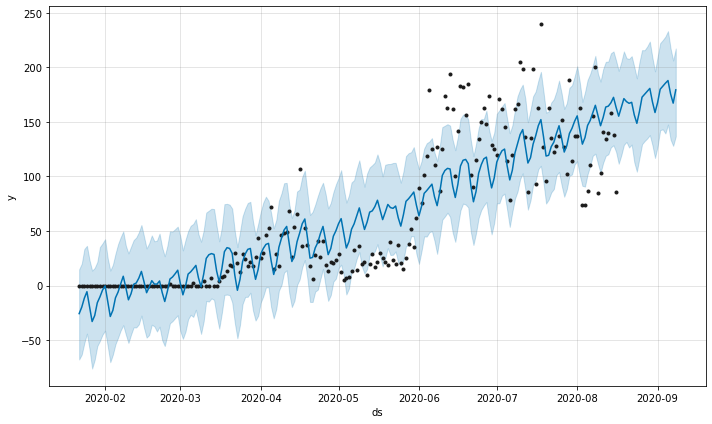

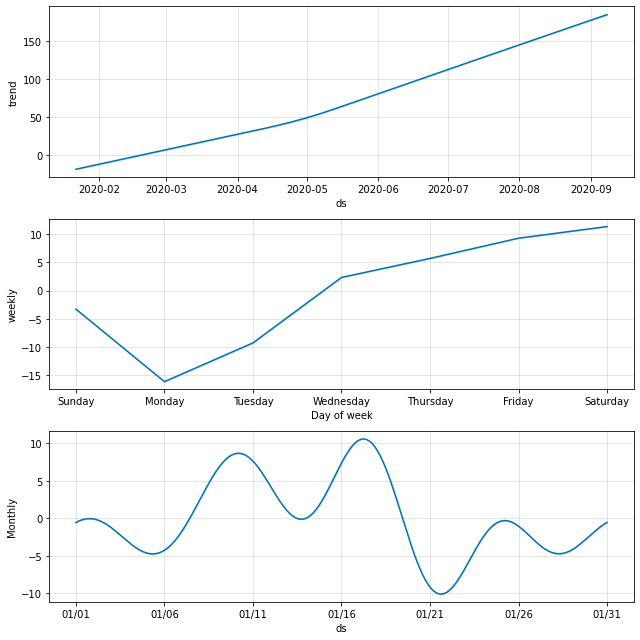

In [42]:
m.plot(predictions_mk);
m.plot_components(predictions_mk);
check_metrics(daily_new_test, predictions_mk)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


R-square Score: -27.07219012884715


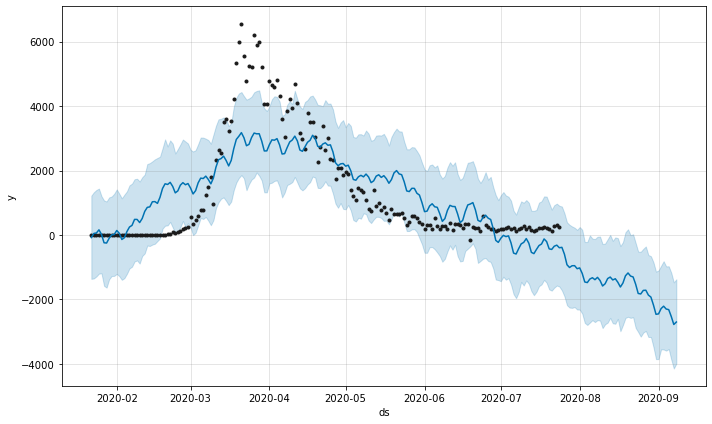

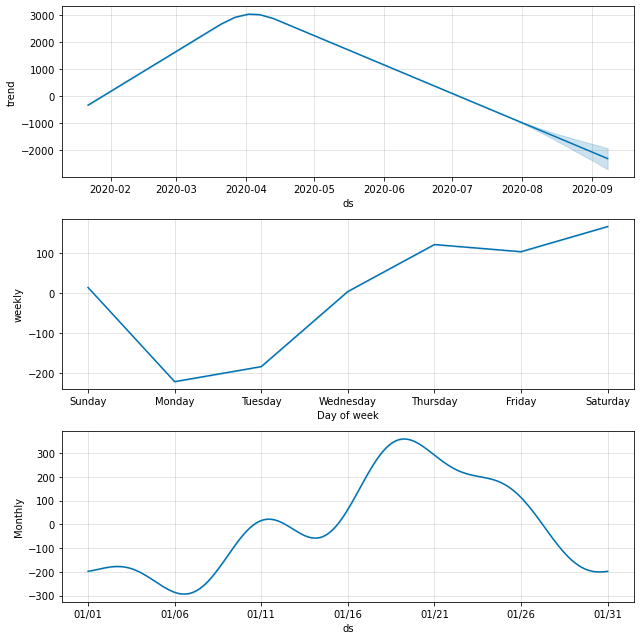

In [43]:
# Italy
data_italy = df_italy[['DATE','DAILY NEW CASES']]
data_italy.columns = ['ds','y']
m = Prophet()
m.add_seasonality(name='Monthly', period=30.42, fourier_order=5)
daily_new_train,daily_new_test, divisor = train_test_split(data_italy, 80)
daily_new_train.shape , daily_new_test.shape
m.fit(daily_new_train)
future_dates_it = m.make_future_dataframe(periods=46)
predictions_it = m.predict(future_dates_it)
predictions_it.head()
m.plot(predictions_it);
m.plot_components(predictions_it);
check_metrics(daily_new_test, predictions_it)

In [44]:
#AutoRegression
df[['DATE','DAILY NEW CASES']]


,DATE,DAILY NEW CASES
0,2020-01-22,0.0
1,2020-01-23,0.0
2,2020-01-24,0.0
3,2020-01-25,0.0
4,2020-01-26,0.0
...,...,...
226,2020-09-04,109.0
227,2020-09-05,127.0
228,2020-09-06,92.0
229,2020-09-07,37.0


<AxesSubplot:xlabel='DATE'>

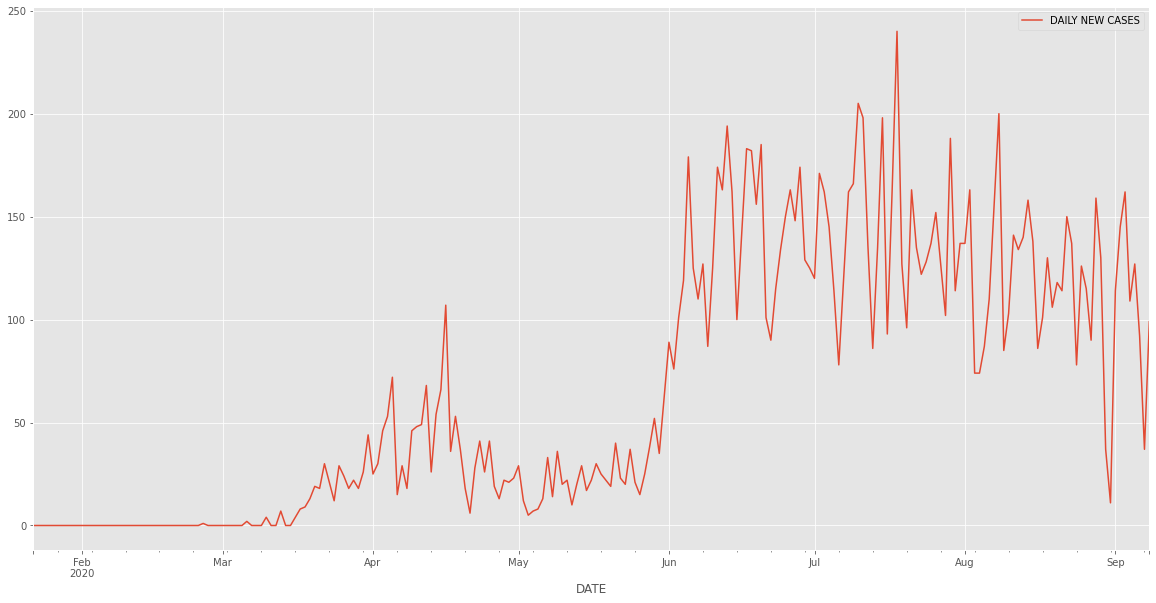

In [45]:
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')

macedonia_data = df[['DATE','DAILY NEW CASES']]
macedonia_data['DATE']=pd.to_datetime(macedonia_data['DATE'])
macedonia_data.set_index('DATE', inplace=True)

macedonia_data.plot()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

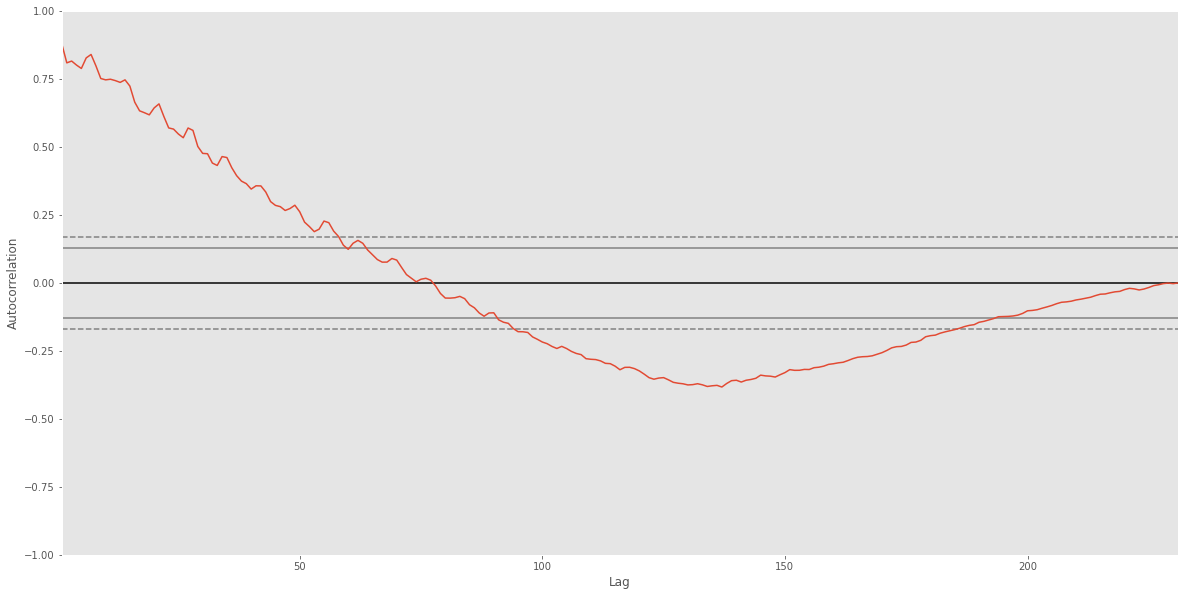

In [46]:
from pandas.plotting import autocorrelation_plot
pd.plotting.autocorrelation_plot(macedonia_data['DAILY NEW CASES'])

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

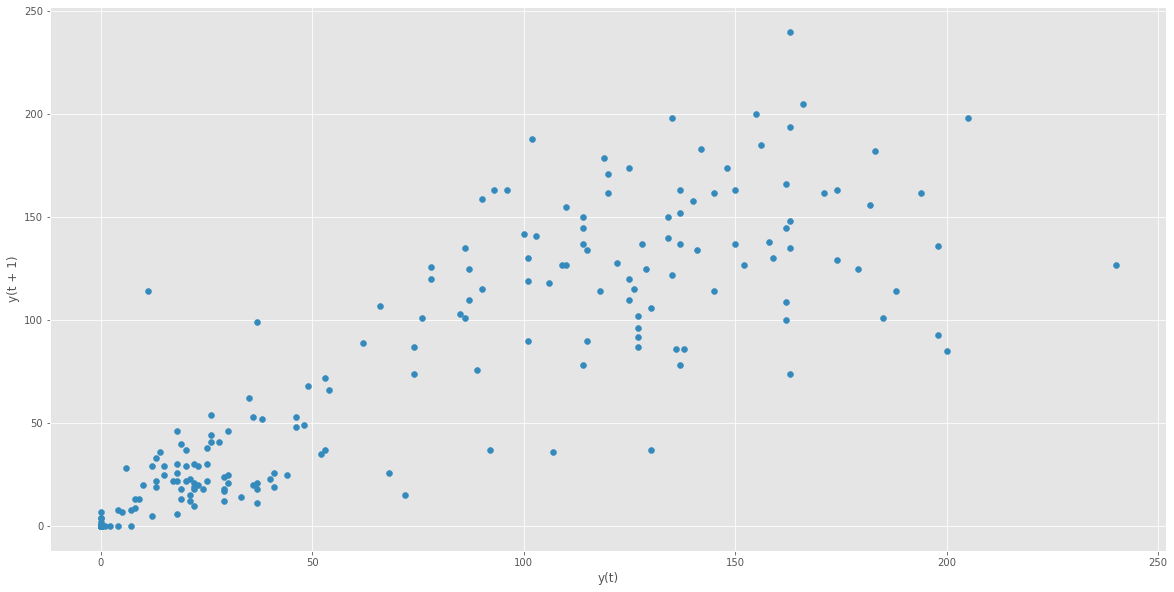

In [47]:
pd.plotting.lag_plot(macedonia_data['DAILY NEW CASES'])

In [48]:
macedonia_data['DAILY NEW CASES'].corr(macedonia_data['DAILY NEW CASES'].shift(5))

0.8028554133971182

In [49]:
macedonia_data['stationary']=macedonia_data['DAILY NEW CASES'].diff()

<AxesSubplot:xlabel='DATE'>

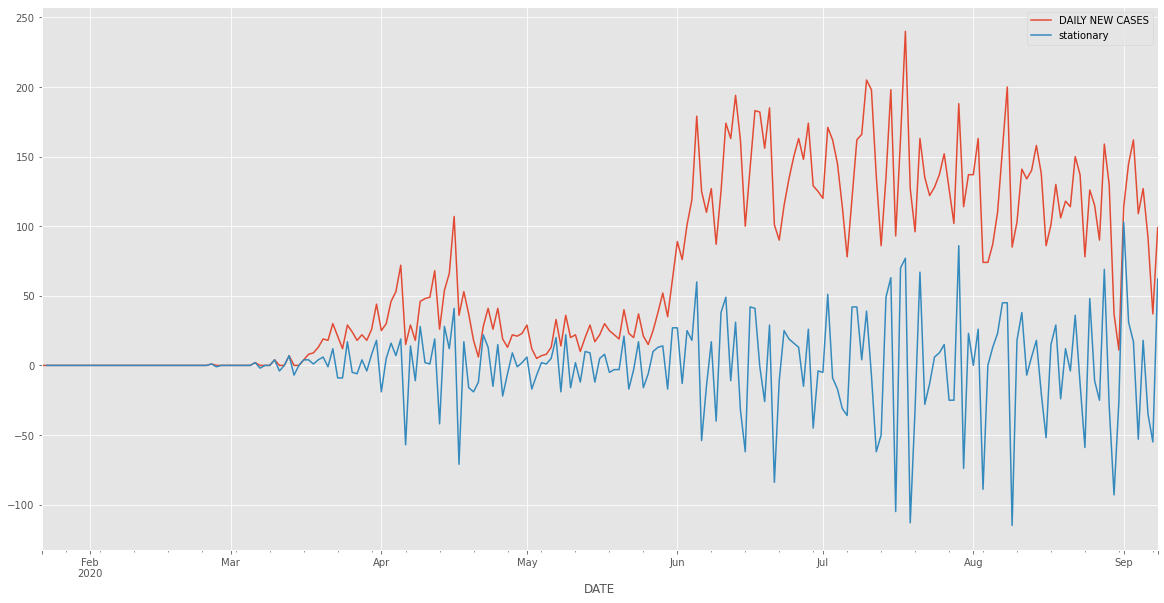

In [50]:
macedonia_data.plot()

In [51]:
from statsmodels.tsa.ar_model import AR

#create train/test datasets
X = macedonia_data['stationary'].dropna()
divisor = round((80/100)*X.shape[0])
train_data = X.iloc[:divisor]
test_data =  X.iloc[divisor:]

#train the autoregression model
model = AR(train_data)
model_fitted = model.fit()

In [52]:
print('The chosen lag value is: %s' % model_fitted.k_ar)

The chosen lag value is: 14


In [53]:
print('The coefficients of the model are:\n %s' % model_fitted.params)

The coefficients of the model are:
 const             1.897041
L1.stationary    -0.485312
L2.stationary    -0.467037
L3.stationary    -0.148020
L4.stationary    -0.233326
L5.stationary    -0.370712
L6.stationary    -0.149206
L7.stationary     0.214923
L8.stationary     0.240283
L9.stationary     0.030828
L10.stationary   -0.106200
L11.stationary   -0.104037
L12.stationary    0.089716
L13.stationary    0.094434
L14.stationary   -0.067903
dtype: float64


In [54]:
test_data

DATE
2020-07-25      9.0
2020-07-26     15.0
2020-07-27    -25.0
2020-07-28    -25.0
2020-07-29     86.0
2020-07-30    -74.0
2020-07-31     23.0
2020-08-01      0.0
2020-08-02     26.0
2020-08-03    -89.0
2020-08-04      0.0
2020-08-05     13.0
2020-08-06     23.0
2020-08-07     45.0
2020-08-08     45.0
2020-08-09   -115.0
2020-08-10     18.0
2020-08-11     38.0
2020-08-12     -7.0
2020-08-13      6.0
2020-08-14     18.0
2020-08-15    -20.0
2020-08-16    -52.0
2020-08-17     15.0
2020-08-18     29.0
2020-08-19    -24.0
2020-08-20     12.0
2020-08-21     -4.0
2020-08-22     36.0
2020-08-23    -13.0
2020-08-24    -59.0
2020-08-25     48.0
2020-08-26    -11.0
2020-08-27    -25.0
2020-08-28     69.0
2020-08-29    -29.0
2020-08-30    -93.0
2020-08-31    -26.0
2020-09-01    103.0
2020-09-02     31.0
2020-09-03     17.0
2020-09-04    -53.0
2020-09-05     18.0
2020-09-06    -35.0
2020-09-07    -55.0
2020-09-08     62.0
Name: stationary, dtype: float64

<AxesSubplot:>

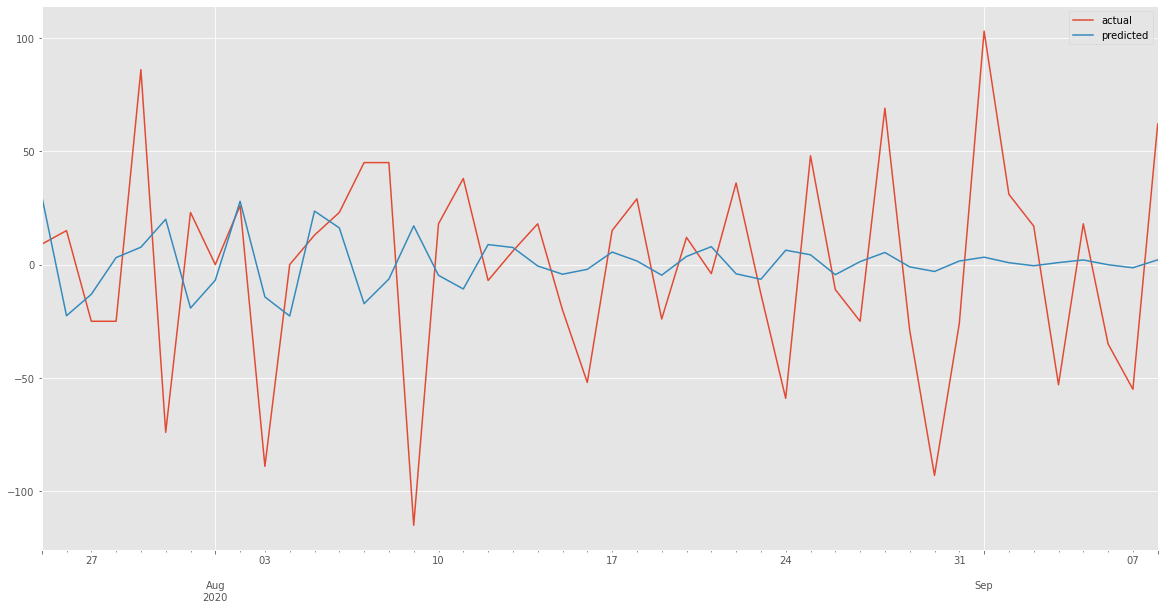

In [55]:
# make predictions 
predictions = model_fitted.predict(
    start=len(train_data), 
    end=len(train_data) + len(test_data)-1, 
    dynamic=False)

# compare test data and predictions
compare_df = pd.concat(
    [test_data,
    predictions], axis=1).rename(
    columns={'stationary': 'actual', 0:'predicted'})

#plot the two values
compare_df.plot()

In [56]:
from sklearn.metrics import r2_score

r2 = r2_score(macedonia_data['stationary'].tail(30), predictions)

ValueError: Found input variables with inconsistent numbers of samples: [30, 46]

In [ ]:
from sklearn.metrics import r2_score

r2 = r2_score(macedonia_data['stationary'].tail(30), predictions)

In [ ]:
r2

In [ ]:
r2

In [ ]:
# make predictions 
predictions = model_fitted.predict(
    start=len(train_data), 
    end=len(train_data) + len(test_data)-1, 
    dynamic=False)

# create a comparison dataframe
compare_df = pd.concat(
    [macedonia_data['stationary'].tail(31),
    predictions], axis=1).rename(
    columns={'stationary': 'actual', 0:'predicted'})

#plot the two values
compare_df.plot()

In [ ]:
from sklearn.metrics import r2_score

r2 = r2_score(macedonia_data['stationary'].tail(30), predictions)

In [ ]:
r2